In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ExerciseAnswers import Answers

pylab.rcParams['figure.figsize'] = 10, 10

In this exercise you will implement two new methods. These could be difficult OR if you use your existing code effectively they could be pretty straightforward.

First you will implement `advance_state` for the controlled 2D drone. 

Then you will implement `set_rotors_angular_velocities` **for the 1D case!** At the end of this notebook we will try to follow a sinusoidally oscillating vertical trajectory.

In [4]:
class Drone2D:
    
    def __init__(self,
                 k_f = 0.1, # value of the thrust coefficient
                 I_x = 0.1, # moment of inertia around the x-axis
                 m = 1.0,   # mass of the vehicle 
                 l = 0.5,   # distance between the center of 
                            #   mass and the propeller axis
                ):
        self.k_f = k_f
        self.I_x = I_x
        self.l = l 
        self.m = m
        self.omega_1 = 0.0
        self.omega_2 = 0.0
        self.g = 9.81
        
        # z, y, phi, z_dot, y_dot, phi_dot
        self.X = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
        
    def advance_state_uncontrolled(self,dt):
        """Advances the state of the drone by dt seconds. 
        Note that this method assumes zero rotational speed 
        for both propellers."""
        
        X_dot = np.array([
            self.X[3], 
            self.X[4], 
            self.X[5], 
            self.g, 
            0.0, 
            0.0])
        
        # Change in state will be 
        self.X = self.X + X_dot * dt
        return self.X
    
    def get_thrust_and_moment(self):
        """Helper function which calculates and returns the 
        collective thrust and the moment about the X axis"""
        f1 = self.k_f * self.omega_1 ** 2
        f2 = self.k_f * self.omega_2 ** 2
        
        # c is often used to indicate "collective" thrust
        c = f1 + f2
        M_x = (f1 - f2) * self.l
        return c, M_x

    @property
    def z_dot_dot(self):
        """Calculates vertical (z) acceleration of drone."""
        c, M_x = self.get_thrust_and_moment()
        phi = self.X[2]
        a_z = self.g - c * math.cos(phi) / self.m
        return a_z

    @property    
    def y_dot_dot(self):
        """Calculates lateral (y) acceleration of drone."""
        c, M_x = self.get_thrust_and_moment()
        phi = self.X[2]
        a_y = c * math.sin(phi) / self.m
        return a_y
    
    @property
    def phi_dot_dot(self):        
        c, M_x = self.get_thrust_and_moment()
        angular_acc = M_x / self.I_x
        return angular_acc
    
    ############################
    # BEGIN TODOS ##############
    
    def advance_state(self, dt): 
        """
        Advances the state of the drone forward by dt seconds.
        """
        
        X_dot = np.array([self.X[3], self.X[4], self.X[5], self.z_dot_dot, self.y_dot_dot, self.phi_dot_dot])
        self.X = self.X + X_dot * dt
        return self.X
    
    def set_rotors_angular_velocities(self,linear_acc):
        """
        Sets self.omega_1 and self.omega_2 to realize the desired
        linear_acc. Note that this is for vertical motion ONLY. It
        is assumed that rotational acceleration and phi is zero
        """
        
        self.omega_1 = -math.sqrt(0.5 * self.m * (self.g - linear_acc) / self.k_f )
        self.omega_2 =  math.sqrt(0.5 * self.m * (self.g - linear_acc) / self.k_f )     

        return self.omega_1, self.omega_2

### Testing `advance_state` and `set_rotors`

In [5]:
# Start by generating a target trajectory and 
# target vertical acceleration
total_time = 3.0
dt = 0.002
t = np.linspace(0.0,total_time,int(total_time/dt))

z_path= 0.5*np.cos(2*t)-0.5
z_dot_dot_path= -2.0*np.cos(2*t)

In [6]:
# Try to follow the trajectory. 
# Store the state history as we go.

drone = Drone2D()

drone_state_history = drone.X

for i in range(t.shape[0]-1):
    
    # setting the propeller velocities 
    drone.set_rotors_angular_velocities(z_dot_dot_path[i])
    
    # calculating the new state vector 
    drone_state = drone.advance_state(dt)
    
    # generate a history of vertical positions for drone
    drone_state_history = np.vstack((drone_state_history, drone_state))

Compare the planned path to the one that has been executed!

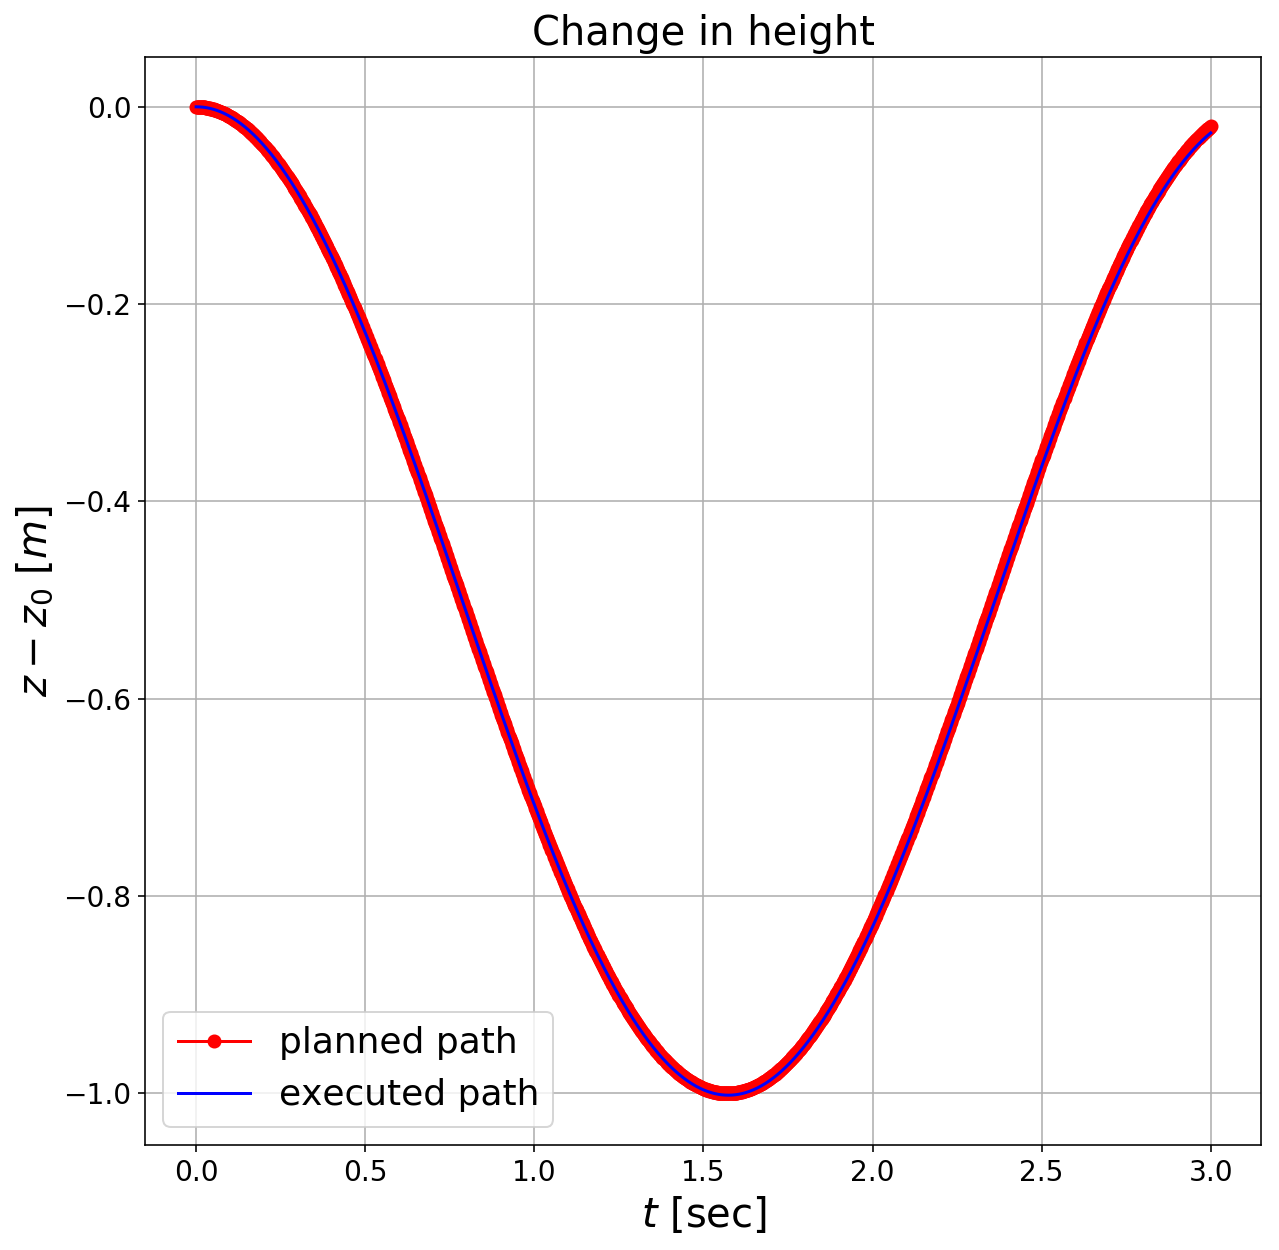

In [7]:
plt.plot(t,z_path,linestyle='-',marker='o',color='red')
plt.plot(t,drone_state_history[:,0],linestyle='-',color='blue')
plt.grid()
plt.title('Change in height').set_fontsize(20)
plt.xlabel('$t$ [sec]').set_fontsize(20)
plt.ylabel('$z-z_0$ [$m$]').set_fontsize(20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['planned path','executed path'],fontsize = 18)
plt.show()